Luscher function for different d and gamma and different l,m. note: gamma = 1 in nr case. 

In [1]:
using FastGaussQuadrature, LinearAlgebra, LegendrePolynomials, Symbolics, Printf, SpecialFunctions, SphericalHarmonics
using LaTeXStrings, Plots

Some necessary functions

In [2]:
function KroneckerDelta(i, j)
    return i == j ? 1 : 0
end

function Kronecker(p,q)
    P = p - q
    if P == [0,0,0]
        return 1
    else return 0
    end
end
function readshelllist()
    file = open("D:\\PhD\\Long-range\\julia code\\finite volume\\shelllist\\shelllist499.txt", "r")
    shells_og = []
    for line in eachline(file)
        row = parse.(Float64, split(line))
        push!(shells_og, row)
    end
    
    close(file)
    return shells_og
end

readshelllist (generic function with 1 method)

In [3]:
###################################################

function coordtranfo(vecd::Vector{Float64})
    r::Float64 = norm(vecd)
    theta::Float64 = acos(vecd[3]/r)
    phi::Float64 = sign(vecd[2])*acos(vecd[1]/norm([vecd[1],vecd[2]]))
    return r, theta, phi
end

function rlYlm(l::Int64,m::Int64,vecd::Vector{Float64})
    r::Float64, theta::Float64, phi::Float64 = coordtranfo(vecd)
    if l == 0
        return 1/sqrt(4*pi)
    elseif vecd == [0.0,0.0,0.0]
        return 0
    elseif m == 0
        return (r^l)*(sqrt((2*l + 1)/(4*pi)))*(sqrt(factorial(l-m)/factorial(l+m)))*Plm(cos(theta),l,m)
    elseif m != 0 && vecd[1:2] == [0.0,0.0]
        return 0
    else
        return (r^l)*(sqrt((2*l + 1)/(4*pi)))*(sqrt(factorial(l-m)/factorial(l+m)))*Plm(cos(theta),l,m)*exp(1im*m*phi)
    end
end

function regz(x::Float64)
    return  sign(x)/(sqrt(x^2 + 10^(-32)))
end

###################################################

@fastmath function summandYamazaki(l::Int64,m::Int64,etasq::Float64,r::Vector{Float64})
    return   rlYlm(l,m,r)*exp(- dot(r,r) + etasq) * regz(dot(r,r) - etasq)
end

@fastmath function summandintegrandYamazaki(l::Int64,m::Int64,gamma1::Int64,etasq::Float64,nd::Float64,gn::Vector{Float64},t::Float64)
    return  gamma1*pi^(1.5)*t^(-1.5)*(-1)^(round(nd))*(-1im)^(l)*rlYlm(l,m,-pi*gn/t)*exp(t * etasq - pi^2 / t * dot(gn,gn))
end


@fastmath function constantpiece(l::Int64,m::Int64,gamma1::Int64)
    return  - gamma1*pi*KroneckerDelta(l, 0)*KroneckerDelta(m, 0)
end

###################################################

@inline function Z00Yamazakilm(l::Int64,m::Int64,d::Vector{Float64},gamma1::Int64,etasq::Float64)
    nsqcut0::Float64= 60.0
    nsqmax::Float64 = 3000.0
    Tol::Float64 = 1.0e-16
    sum1::Float64 = 0.0
    sum2::Float64 = 0.0
    sum3::Float64 = 0.0
    flag::Int64 = 0
    D::Float64 = norm(d)
    leggauss_quad::Tuple{Vector{Float64}, Vector{Float64}} = gausslegendre(20)
    sample_points::Vector{Float64} = (0.5 .+ 0.5*leggauss_quad[1])
    weights::Vector{Float64} = 0.5*leggauss_quad[2]
    if etasq >= 0.0
         errfunc::Float64 = (pi*gamma1)*(1 - exp(etasq) + (pi)^(1/2)*sqrt(etasq)*erfi(sqrt(etasq))) 
    else 
         errfunc = (pi*gamma1)*(1 - exp(etasq) - (pi)^(1/2)*sqrt(-etasq)*(erfi(sqrt(-etasq))))
    end
    
     sum3 += errfunc*KroneckerDelta(l, 0)*KroneckerDelta(m, 0)
    
    r0::Vector{Float64} = d / (2.0 * gamma1)
    sum1 += summandYamazaki(l,m,etasq,r0)
    
    if etasq>30.0
        @printf("\nWarning: positive etaSq(%lf)!",etasq)
    end
    
     nsqcutr::Float64 = 2.0*((gamma1*sqrt(abs(etasq)) + D / 2.0)^(2) + 1.0)
    
    if etasq > 0.0 && nsqcutr > nsqcut0
        nsqcut::Float64 = nsqcutr
    else 
        nsqcut = nsqcut0
    end
    
    shells_og = readshelllist()
    
    i::Int64 = 2
    nsq= 1.0
    while nsq <= nsqmax && flag == 0
        nsq::Float64 = shells_og[i][3]
        dsum1::Float64 = 0.0
        dsum2::Float64 = 0.0
        while shells_og[i][3] == nsq
            vecnum::Float64 = shells_og[i][4]
            shellsum1::Float64 = 0.0
            shellsum2::Float64 = 0.0
            if D == 0
                n::Vector{Float64} = shells_og[i][5:7]
                nd::Float64 = 0.0
                gn::Vector{Float64} = n
                r::Vector{Float64} = n
                shellsum1 += vecnum * summandYamazaki(l,m,etasq,r)
                if nsq<=nsqcut0
                    shellsum2 = sum([@inbounds vecnum * weights[j]*summandintegrandYamazaki(l,m,gamma1,etasq,nd,gn,sample_points[j]) for j in 1:20])
#                     shell_sum = @.(vecnum * weights*summandintegrandYamazaki(l,m,gamma1,etasq,nd,gn,sample_points))
#                     shellsum2 += sum(shell_sum)
#                     shell_sum = 0
                    # for ii in 1:20
                    #      shellsum2 += vecnum * weights[ii]*summandintegrandYamazaki(l,m,gamma1,etasq,nd,gn,sample_points[ii])
                    # end
                end
            else
                j::Int64 = 1
                while j <= vecnum
                    n = shells_og[i][5+3*(j-1):7+3*(j-1)]
                    nd = dot(n,d)
                    npara::Vector{Float64} = nd*(d/D^2)
                    nperp::Vector{Float64} = n - npara
                    gn = gamma1*npara + nperp
#                     gn = norm(gn1)
                    r = 1/gamma1 * (npara - d/2) + nperp
#                     r = norm(r1)
                     shellsum1 += summandYamazaki(l,m,etasq,r)
                    if nsq<=nsqcut0
                        shellsum2 = sum([@inbounds weights[ii]*summandintegrandYamazaki(l,m,gamma1,etasq,nd,gn,sample_points[ii]) for ii in 1:20])
#                         shell_sum = @.(weights*summandintegrandYamazaki(l,m,gamma1,etasq,nd,gn,sample_points))
#                         shellsum2 += sum(shell_sum)
#                         shell_sum = 0
                        # for ii in 1:20
                        #      shellsum2 += weights[ii]*summandintegrandYamazaki(l,m,gamma1,etasq,nd,gn,sample_points[ii])
                        # end
                    end
                    j += 1
                end
            end
            dsum1 += shellsum1
            dsum2 += shellsum2
            i += 1
        end
        sum1 += dsum1
        sum2 += dsum2
        #error ananlysis
        
        if nsq > nsqcut
#             gn = sqrt(nsq)
#             r = 1/gamma1 * (sqrt(nsq) - D/2.0)
#              abserr = abs(errorYamazaki(gamma1,etasq,r))
#             if abserr<Tol
            flag = 1
#             end
        end
    end
    
    if flag==0
        @printf("<Warning: Z00(%d)>\n",round.(d))
    end
    sum3 += constantpiece(l,m,gamma1)
    return sum1 + sum2 + sum3
end

###################################################

Z00Yamazakilm (generic function with 1 method)

In [4]:
etasq = LinRange(1,10,100)
A = [real(Z00Yamazakilm(0,0,[0.0,0.0,0.0],1,etasq[i])) for i in 1:100]

100-element Vector{Float64}:
   1.350857264344467
 -18.33029653275018
  -8.309265005895796
  -4.381914607233901
  -1.847372513289777
   0.3012776898935443
   2.509715563357021
   5.179699414879252
   9.001715406782171
  15.878748946594985
   ⋮
 -22.735983655237305
 -12.858413959931113
  -5.63361218019736
   0.7655567140227504
   7.546068898589056
  16.292849006709275
  30.927487473575184
  70.19542970176826
   4.424749084207178

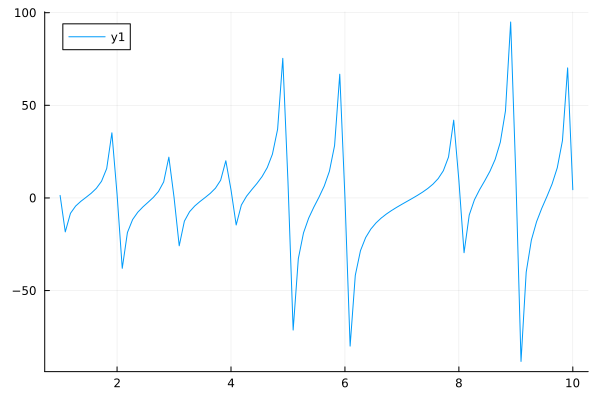

In [22]:
using Plots
plot(etasq, A)
